# Part 2: Tweet Analysis using Topic Modeling and Sentiment Analysis

### Importing libraries

In [1]:
import pandas as pd
import csv
import datetime
import matplotlib.pyplot as plt
import langid
import numpy as np

#NLTK
import nltk
from nltk.corpus import stopwords, wordnet
from nltk import download, FreqDist
download('punkt')
download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk import ngrams
from nltk.probability import MLEProbDist
from nltk.stem import WordNetLemmatizer

#WordCloud
from wordcloud import WordCloud
from PIL import Image

#Sentiment Analysis
from pattern.en import sentiment
from pattern.en import parse
from pattern.en import pprint
import string 
import re

#Topic Modeling
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

#import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

nlp = spacy.load('en_core_web_lg')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Linds\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Linds\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading the data

In [2]:
df = pd.read_csv('rhino_tweets.csv')

In [3]:
df['Dates'] = pd.to_datetime(df['Timestamp']).dt.date
df['Time'] = pd.to_datetime(df['Timestamp']).dt.time
df['Year'] = pd.DatetimeIndex(df['Dates']).year
df['Month'] = pd.DatetimeIndex(df['Dates']).month
df['Day'] = pd.DatetimeIndex(df['Dates']).day

In [4]:
#converting floats to string

df.at[168,'Likes']='2893'
df.at[681,'Likes']='2229'
df.at[795,'Likes']='2815'
df.at[2800,'Likes']='2999'
df.at[2920,'Likes']='1695'

df['Likes'] = pd.to_numeric(df['Likes'])

### Pre-processing the data

In [5]:
df = df[df['Username'] != 'ITD Print Solutions'] #remove username since not related to topic
df.drop_duplicates(subset=['Text', 'Username'],inplace=True) #remove tweets that are duplicates 

df['language'] = [langid.classify(tweet)[0] for tweet in df['Text']] #select only english tweets
df = df[df['language'] == 'en']
df['Text'] = [text.lower() for text in df['Text']] #lowercase text

In [6]:
#removing stopwords
additional  = ['rt','rts','retweet']
stopwords = set().union(stopwords.words('english'),additional)

In [7]:
#remove twitter handles, hyperlinks, non-alphanumeric characters, whitespace
df['processed_text'] = df['Text'].str.replace('(@[a-z0-9]+)\w+',' ').str.replace('(http\S+)', ' ').str.replace('([^0-9a-z \t])',' ').str.replace(' +',' ')

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \S
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \S
C:\Users\Linds\AppData\Local\Temp\ipykernel_14168\1538642464.py:2: DeprecationWarning: invalid escape sequence \w
  df['processed_text'] = df['Text'].str.replace('(@[a-z0-9]+)\w+',' ').str.replace('(http\S+)', ' ').str.replace('([^0-9a-z \t])',' ').str.replace(' +',' ')
C:\Users\Linds\AppData\Local\Temp\ipykernel_14168\1538642464.py:2: DeprecationWarning: invalid escape sequence \S
  df['processed_text'] = df['Text'].str.replace('(@[a-z0-9]+)\w+',' ').str.replace('(http\S+)', ' ').str.replace('([^0-9a-z \t])',' ').str.replace(' +',' ')
C:\Users\Linds\AppData\Local\Temp\ipykernel_14168\1538642464.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed_text'] = df['Text'].str.replace('(@[a-z0-9]+)\w+',' ').str.replace('(

In [8]:
#divide it into three years
df_2019 = df[df['Year'] == 2019].reset_index()
df_2020 = df[df['Year'] == 2020].reset_index()
df_2021 = df[df['Year'] == 2021].reset_index()

In [9]:
print(len(df_2019),len(df_2020),len(df_2021))

1922 1230 1030


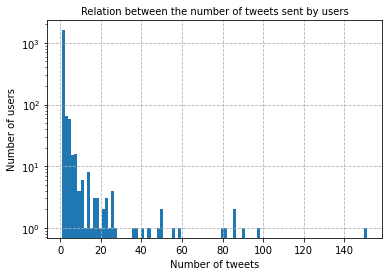

In [10]:
#plot the relation between the number of tweets sent by each user. 
counts = df.Username.value_counts()
count_list = list(counts)
plt.hist(count_list, log=True, bins=100)
plt.xlabel('Number of tweets', size=10)
plt.ylabel('Number of users',size=10)
plt.title("Relation between the number of tweets sent by users", size=10)
plt.grid(linestyle='--')
#plt.savefig("tweetuser.jpg")
plt.show()

In [11]:
# List the 10 most frequent usernames
print(counts.nlargest(10))

# Print some of the tweets of each of the 5 most frequent usernames
most_frequent = counts.nlargest(5).to_dict()
# for each username in the set
for name in most_frequent.keys():
  # get a sample of the associated tweets and print
    sample = df[df.Username == name].Text.sample(5)
    print(name)
    print(sample)

Sue Spurgin                     151
Planet Rhino                     97
Save the Rhino International     90
Helping Rhinos                   85
Dr Will Fowlds                   85
S.P.O.T.S                        81
The Boucher Legacy               80
Desiree_Laverne                  58
Seb (travelcomments)             55
VETPAW                           50
Name: Username, dtype: int64
Sue Spurgin
4481    @sapoliceservice\n great work#south africa r1....
4405    #southafrican #rhino #poaching increased 50% t...
3713    stockpile theft in #africa blamed for illegal ...
2415    #southafrica: great news for #rhinofriday - sk...
2826    #namibia senior cop with syndicate connections...
Name: Text, dtype: object
Planet Rhino
4445    "the hawks arrested a 36-year-old man in gaute...
2670    a concerning read from \n@oxciej\n looking int...
2555    "although some people involved with the crime ...
4462    "they were convicted for illegally trading in ...
2456    two successful poaching prosec

#### Plotting the distribution over the hashtags

In [12]:
string2 = "wildlifecrime #rhino"

anti2019 = 0
anti2020 = 0
anti2021 = 0

['#antipoaching', '#wildlifecrime', '#poaching']

for tweet in df_2019['Text']:
    if '#antipoaching' in tweet:
        if '#rhino' in tweet:
            anti2019 += 1

for tweet in df_2020['Text']:
    if '#antipoaching' in tweet:
        if '#rhino' in tweet:
            anti2020 += 1
            
for tweet in df_2021['Text']:
    if '#antipoaching' in tweet:
        if '#rhino' in tweet:
            anti2021 += 1

wild2019 = 0
wild2020 = 0
wild2021 = 0

for tweet in df_2019['Text']:
    if '#wildlifecrime' in tweet:
        if '#rhino' in tweet:
            wild2019 += 1

for tweet in df_2020['Text']:
    if '#wildlifecrime' in tweet:
        if '#rhino' in tweet:
            wild2020 += 1
            
for tweet in df_2021['Text']:
    if '#wildlifecrime' in tweet:
        if '#rhino' in tweet:
            wild2021 += 1
            
poaching2019 = 0
poaching2020 = 0
poaching2021 = 0

for tweet in df_2019['Text']:
    if '#poaching' in tweet:
        if '#rhino' in tweet:
            poaching2019 += 1

for tweet in df_2020['Text']:
    if '#poaching' in tweet:
        if '#rhino' in tweet:
            poaching2020 += 1
            
for tweet in df_2021['Text']:
    if '#poaching' in tweet:
        if '#rhino' in tweet:
            poaching2021 += 1
            
justice2019 = 0
justice2020 = 0
justice2021 = 0

for tweet in df_2019['Text']:
    if '#justiceforrhino' in tweet:
        justice2019 += 1
        
for tweet in df_2020['Text']:
    if '#justiceforrhino' in tweet:
        justice2020 += 1
        
for tweet in df_2021['Text']:
    if '#justiceforrhino' in tweet:
        justice2021 += 1        

poachingc2019 = 0
poachingc2020 = 0
poachingc2021 = 0

for tweet in df_2019['Text']:
    if '#poaching' in tweet:
        if '#rhinoceros' in tweet:
            poachingc2019 += 1

for tweet in df_2020['Text']:
    if '#poaching' in tweet:
        if '#rhinoceros' in tweet:
            poachingc2020 += 1
            
for tweet in df_2021['Text']:
    if '#poaching' in tweet:
        if '#rhinoceros' in tweet:
            poachingc2021 += 1
            
horn2019 = 0
horn2020 = 0
horn2021 = 0

for tweet in df_2019['Text']:
    if '#rhinohorn' in tweet:
        horn2019 += 1
        
for tweet in df_2020['Text']:
    if '#rhinohorn' in tweet:
        horn2020 += 1
        
for tweet in df_2021['Text']:
    if '#rhinohorn' in tweet:
        horn2021 += 1   
        
save2019 = 0
save2020 = 0
save2021 = 0

for tweet in df_2019['Text']:
    if '#savetherhino' in tweet:
        save2019 += 1
        
for tweet in df_2020['Text']:
    if '#savetherhino' in tweet:
        save2020 += 1
        
for tweet in df_2021['Text']:
    if '#savetherhino' in tweet:
        save2021 += 1  
        
rhino2019 = 0
rhino2020 = 0
rhino2021 = 0

for tweet in df_2019['Text']:
    if '#rhinopoaching' in tweet:
        rhino2019 += 1
        
for tweet in df_2020['Text']:
    if '#rhinopoaching' in tweet:
        rhino2020 += 1
        
for tweet in df_2021['Text']:
    if '#rhinopoaching' in tweet:
        rhino2021 += 1  

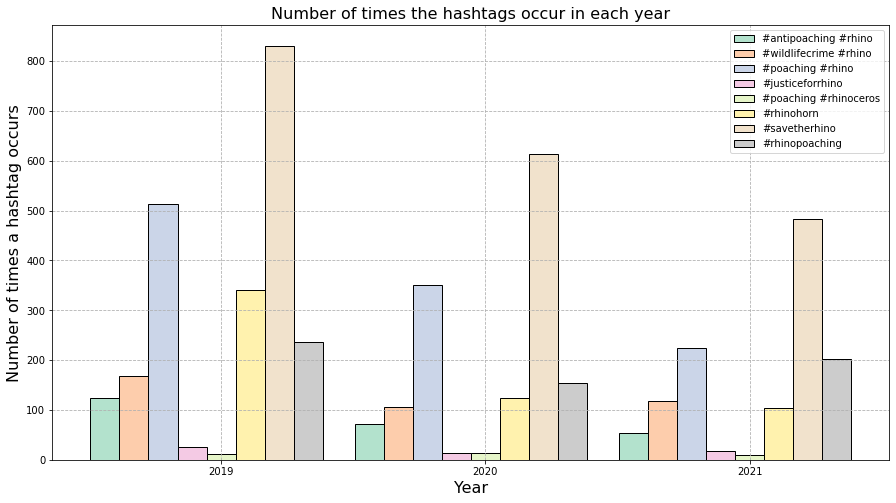

In [13]:
anti = [anti2019,anti2020,anti2021]
wild = [wild2019,wild2020,wild2021]
poaching = [poaching2019, poaching2020, poaching2021]
justice = [justice2019, justice2020, justice2021]
poachingc = [poachingc2019, poachingc2020, poachingc2021]
horn = [horn2019,horn2020,horn2021]
save = [save2019,save2020,save2021]
rhino = [rhino2019,rhino2020,rhino2021]
total = [anti[0]+wild[0]+poaching[0]+justice[0]+poachingc[0]+horn[0]+save[0]+rhino[0], 
         anti[1]+wild[1]+poaching[1]+justice[1]+poachingc[1]+horn[1]+save[1]+rhino[1],
         anti[2]+wild[2]+poaching[2]+justice[2]+poachingc[2]+horn[2]+save[2]+rhino[2]]

colors = iter([plt.cm.Pastel2(i) for i in range(9)])

n=3
r = np.arange(n)
width = 0.11
f, ax = plt.subplots(figsize=(15,8)) 
plt.bar(r, anti, color = [next(colors)],
        width = width, edgecolor = 'black',
        label='#antipoaching #rhino')
plt.bar(r + width, wild, color = [next(colors)],
        width = width, edgecolor = 'black',
        label='#wildlifecrime #rhino')
plt.bar(r + width*2, poaching, color = [next(colors)],
        width = width, edgecolor = 'black',
        label='#poaching #rhino')
plt.bar(r + width*3, justice, color = [next(colors)],
        width = width, edgecolor = 'black',
        label='#justiceforrhino')  
plt.bar(r + width*4, poachingc, color = [next(colors)],
        width = width, edgecolor = 'black',
        label='#poaching #rhinoceros')
plt.bar(r + width*5, horn, color = [next(colors)],
        width = width, edgecolor = 'black',
        label='#rhinohorn') 
plt.bar(r + width*6, save, color = [next(colors)],
        width = width, edgecolor = 'black',
        label='#savetherhino')
plt.bar(r + width*7, rhino, color = [next(colors)],
        width = width, edgecolor = 'black',
        label='#rhinopoaching') 

plt.xlabel("Year", size=16)
plt.ylabel("Number of times a hashtag occurs", size=16)
plt.title("Number of times the hashtags occur in each year", size=16)
  
plt.grid(linestyle='--')
plt.xticks(r+width*4,['2019','2020','2021'])
#plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.savefig('hashtag_distribution.jpg')
plt.show()

### N-grams

In [14]:
df['bigrams'] = df['processed_text'].apply(lambda x: [i for i in x.split() if not i in stopwords]).apply(lambda row: list(nltk.ngrams(row, 2)))
df['trigrams'] = df['processed_text'].apply(lambda x: [i for i in x.split() if not i in stopwords]).apply(lambda row: list(nltk.ngrams(row, 3)))

In [15]:
df_2019['trigrams'] = df_2019['processed_text'].apply(lambda x: [i for i in x.split() if not i in stopwords]).apply(lambda row: list(nltk.ngrams(row, 3)))
df_2020['trigrams'] = df_2020['processed_text'].apply(lambda x: [i for i in x.split() if not i in stopwords]).apply(lambda row: list(nltk.ngrams(row, 3)))
df_2021['trigrams'] = df_2021['processed_text'].apply(lambda x: [i for i in x.split() if not i in stopwords]).apply(lambda row: list(nltk.ngrams(row, 3)))

In [16]:
def plot_dist_as_cloud(word_dist):
    prob_dist = MLEProbDist(word_dist)
    viz_dict = {}
    for word_tuple in word_dist:
        string = ' '.join(word_tuple)
        viz_dict[string] = prob_dist.prob(word_tuple)
    mask = np.array(Image.open('rhino2.png'))
    cloud = WordCloud(width=1000,height=600,mask=mask, background_color = 'white').generate_from_frequencies(viz_dict)
  
    plt.figure(figsize = (20,20))
    plt.imshow(cloud, interpolation='bilinear')

    plt.axis("off")

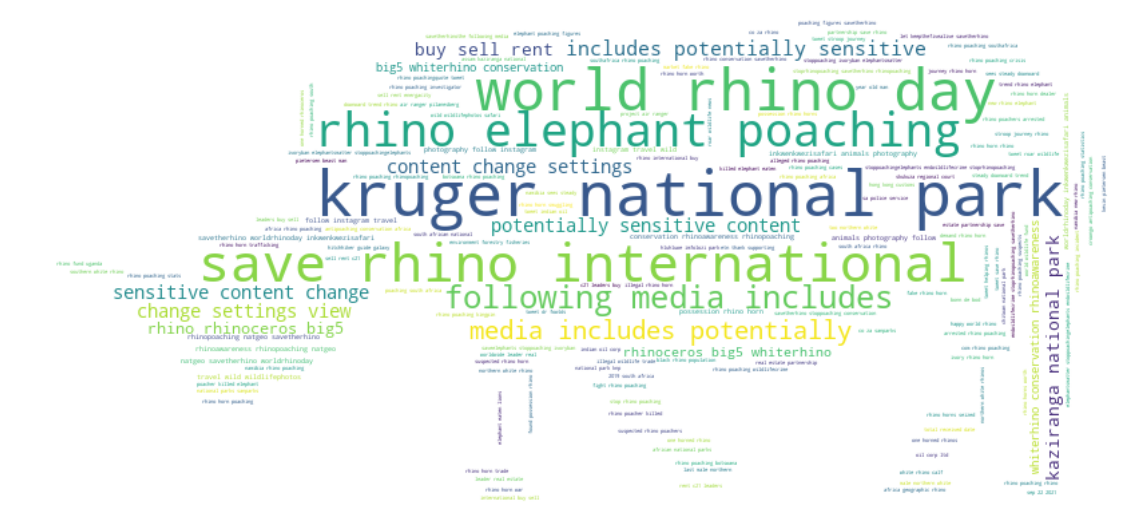

In [17]:
word_dist = FreqDist()
for grams in df['trigrams']:
      word_dist.update(FreqDist(grams))

cloud = plot_dist_as_cloud(word_dist)
#plt.savefig('cloudtrigram.png')

## Sentiment Analysis


In [18]:
#df.sample(n=100).to_csv('twitter-data.csv', index=False)
#read_file = pd.read_excel ('tweets_labelled.xlsx')
#read_file.to_csv('tweets_labelled.csv', index = None, header=True)

In [19]:
#Sample of labelled twitter data
df_label = pd.read_csv('tweets_labelled.csv')
df_label['Label'].value_counts()

 0    65
-1    20
 1    15
Name: Label, dtype: int64

In [20]:
#Adding the sentiment from Pattern library
df_label['Score'] = [sentiment(text)[0] for text in df_label['processed_text']]
df_label[['processed_text','Label','Score']].head(10)

,processed_text,Label,Score
0,"['poachers', 'broke', 'french', 'zoo', 'kill',...",-1,-0.060714
1,"['news', 'poachers', 'kill', 'rhinos', 'corona...",0,0.000000
2,"['two', 'poaching', 'attempts', 'foiled', 'kzn...",0,0.000000
3,"['worldrhinoday2021', 'observed', 'tamilnadu',...",0,0.000000
4,"['three', 'suspects', 'arrested', 'dealing', '...",0,0.000000
5,"['four', 'staff', 'two', 'volunteers', 'women'...",0,0.250000
6,"['planet', 'sos', 'new', 'technology', 'save',...",0,0.218182
7,"['southafrica', 'kzn', 'sadly', 'ezemvelo', 'k...",-1,-0.200000
8,"['huge', 'thanks', 'haste', 'ltd', 'volunteeri...",1,0.241667
9,"['month', 'ago', 'kama', 'rhino', 'sanctuary',...",1,0.600000


In [21]:
df_label['Score'].apply(lambda x: round(x,)).value_counts()

 0    93
 1     4
-1     3
Name: Score, dtype: int64

## Topic Modeling

In [22]:
all_words = [word for tokens in df['processed_text'] for word in tokens]
tweet_lengths = [len(tokens) for tokens in df['processed_text']]
vocab = sorted(list(set(all_words)))

print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(tweet_lengths)))

913773 words total, with a vocabulary size of 37
Max tweet length is 598


C:\Users\Linds\anaconda3\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Linds\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Linds\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


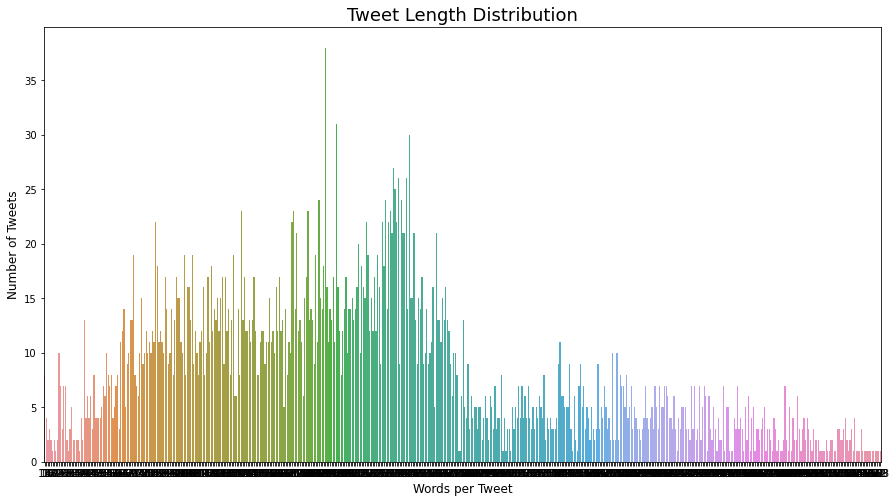

In [23]:
import seaborn as sns

plt.figure(figsize = (15,8))
sns.countplot(tweet_lengths)
plt.title('Tweet Length Distribution', fontsize = 18)
plt.xlabel('Words per Tweet', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize = 12)
plt.show()

In [24]:
#function used to add the Part-of-Speech tag

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

In [25]:
#function to lemmatize the words dependent on the POS-tag

def lemmatizer(sentence):
    wnl = WordNetLemmatizer()
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence)) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:       
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(wnl.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence

In [26]:
df_2019['lemma'] = df_2019['processed_text'].apply(lambda x: lemmatizer(x))
df_2020['lemma'] = df_2020['processed_text'].apply(lambda x: lemmatizer(x))
df_2021['lemma'] = df_2021['processed_text'].apply(lambda x: lemmatizer(x))

df['lemma'] = df['processed_text'].apply(lambda x: lemmatizer(x))

In [27]:
df_2019['lemma_tokens'] = df_2019['lemma'].apply(lambda x: [i for i in x.split() if not i in stopwords])
df_2020['lemma_tokens'] = df_2020['lemma'].apply(lambda x: [i for i in x.split() if not i in stopwords])
df_2021['lemma_tokens'] = df_2021['lemma'].apply(lambda x: [i for i in x.split() if not i in stopwords])

df['lemma_tokens'] = df['lemma'].apply(lambda x: [i for i in x.split() if not i in stopwords])

#### Run the LDA Topic Model

##### Expected Topics:
- News articles: arrest, poacher, kiler, suspect, crime.
- Supporting messages: support, wildlife, save, help, thanks, protect, endangered.
- Personal views: horrific, terrible, treat, disgusting, coward, heartbreaking.

In [28]:
""" 2019 """

num_topics = 3

id2word = Dictionary(df_2019['lemma_tokens']) #create the dictionary
#id2word.filter_extremes(no_below=2, no_above=.76, keep_n=None) #filter out extremes

corpus = [id2word.doc2bow(doc) for doc in df_2019['lemma_tokens']] #create the corpus

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       iterations=50,
                                       passes=10,
                                       alpha=50/4,
                                       eta = 0.1,
                                       num_topics=num_topics)

cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, coherence='u_mass')
cm1 = CoherenceModel(model=lda_model, texts = df_2019['lemma_tokens'], corpus=corpus, dictionary=id2word, coherence='c_v')

# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
pprint(cm.get_coherence())
pprint(cm1.get_coherence())

[(0,
  '0.042*"rhino" + 0.017*"poach" + 0.016*"savetherhino" + 0.010*"horn" + '
  '0.009*"wildlife" + 0.008*"2019" + 0.008*"africa" + 0.007*"rhinohorn" + '
  '0.007*"conservation" + 0.007*"tweet"'),
 (1,
  '0.061*"rhino" + 0.019*"savetherhino" + 0.015*"poach" + 0.014*"horn" + '
  '0.008*"wildlife" + 0.007*"rhinohorn" + 0.006*"2019" + 0.006*"africa" + '
  '0.005*"poaching" + 0.005*"animal"'),
 (2,
  '0.053*"rhino" + 0.018*"poach" + 0.016*"savetherhino" + 0.015*"horn" + '
  '0.008*"rhinohorn" + 0.008*"wildlife" + 0.007*"tweet" + 0.007*"2019" + '
  '0.007*"conservation" + 0.006*"africa"')]
-2.3717266695954824
0.3140967118324916


In [29]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics()]
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
rhino poach savetherhino horn wildlife 2019 africa rhinohorn conservation tweet

------ Topic 1 ------
rhino savetherhino poach horn wildlife rhinohorn 2019 africa poaching animal

------ Topic 2 ------
rhino poach savetherhino horn rhinohorn wildlife tweet 2019 conservation africa



In [30]:
# Visualize the topics
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.012118 -0.029702       1        1  33.381391
0     -0.032986  0.004826       2        1  33.334654
1      0.020868  0.024877       3        1  33.283954, topic_info=             Term         Freq        Total Category  logprob  loglift
11          rhino  2116.000000  2116.000000  Default  30.0000  30.0000
398             5    64.000000    64.000000  Default  29.0000  29.0000
32   conservation   234.000000   234.000000  Default  28.0000  28.0000
124          horn   520.000000   520.000000  Default  27.0000  27.0000
29         animal   149.000000   149.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
147         tweet    68.711268   255.532593   Topic3  -5.2811  -0.2133
532          make    46.050791   136.502664   Topic3  -5.6813   0.0135
65           year    48.767935   150.800169   Topic3  -5.6240  -0.0288
0               1    45.374038   140.323008   Topic3  -5.6961  -0.0289
32   conservation    54.308953   234.534039   Topic3  -5.5164  -0.3628

[284 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.377700     1
0         2  0.299309     1
0         3  0.320689     1
5063      1  0.915827  13th
4835      3  0.810305   158
...     ...       ...   ...
65        2  0.305039  year
65        3  0.324933  year
379       1  0.208077    za
379       2  0.297252    za
379       3  0.505329    za

[360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

### Evaluation

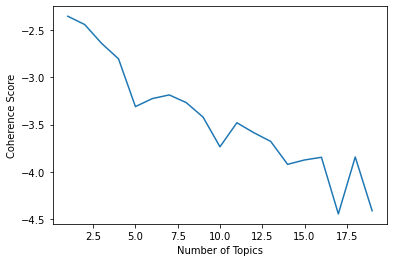

In [31]:
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=id2word, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, coherence='u_mass')
    topics.append(i)
    score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.savefig("u_mass_2019.jpg")
plt.show()

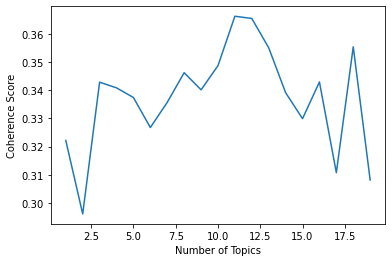

In [32]:
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=id2word, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = df_2019['lemma_tokens'], corpus=corpus, dictionary=id2word, coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.savefig("v_2019.jpg")
plt.show()

In [33]:
""" 2020 """

num_topics = 3

id2word = Dictionary(df_2020['lemma_tokens'])
#id2word.filter_extremes(no_below=2, no_above=.6, keep_n=None)

corpus = [id2word.doc2bow(doc) for doc in df_2020['lemma_tokens']]

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       iterations=50,
                                       num_topics=num_topics)
cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, coherence='u_mass')
cm1 = CoherenceModel(model=lda_model, texts = df_2020['lemma_tokens'], corpus=corpus, dictionary=id2word, coherence='c_v')

# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
pprint(cm.get_coherence())
pprint(cm1.get_coherence())

[(0,
  '0.063*"rhino" + 0.022*"poach" + 0.013*"savetherhino" + 0.012*"horn" + '
  '0.009*"africa" + 0.008*"wildlife" + 0.008*"poaching" + 0.008*"conservation" '
  '+ 0.006*"2020" + 0.006*"poacher"'),
 (1,
  '0.034*"rhino" + 0.019*"savetherhino" + 0.012*"poach" + 0.006*"reply" + '
  '0.006*"wildlife" + 0.006*"year" + 0.006*"poacher" + 0.005*"rhinohorn" + '
  '0.005*"horn" + 0.005*"tweet"'),
 (2,
  '0.044*"rhino" + 0.025*"savetherhino" + 0.009*"horn" + 0.008*"animal" + '
  '0.008*"poach" + 0.008*"worldrhinoday" + 0.008*"rhinoceros" + '
  '0.007*"conservation" + 0.007*"rhinopoaching" + 0.006*"whiterhino"')]
-3.2041871252554768
0.43440084278670166


In [34]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics()]
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
rhino poach savetherhino horn africa wildlife poaching conservation 2020 poacher

------ Topic 1 ------
rhino savetherhino poach reply wildlife year poacher rhinohorn horn tweet

------ Topic 2 ------
rhino savetherhino horn animal poach worldrhinoday rhinoceros conservation rhinopoaching whiterhino



In [35]:
# Visualize the topics
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.035085  0.025812       1        1  52.388875
1      0.011552 -0.036251       2        1  24.024289
2     -0.046637  0.010439       3        1  23.586836, topic_info=               Term        Freq       Total Category  logprob  loglift
7      savetherhino  480.000000  480.000000  Default  30.0000  30.0000
808   worldrhinoday   74.000000   74.000000  Default  29.0000  29.0000
556      whiterhino   48.000000   48.000000  Default  28.0000  28.0000
265      rhinoceros   81.000000   81.000000  Default  27.0000  27.0000
826     photography   41.000000   41.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
2580      rhinohorn   19.138113   86.429332   Topic3  -5.8309  -0.0632
0              2020   23.468465  143.598998   Topic3  -5.6269  -0.3669
45             year   19.160711  105.507274   Topic3  -5.8297  -0.2614
184             com   17.434486  113.099259   Topic3  -5.9241  -0.4253
281        poaching   16.855840  149.974698   Topic3  -5.9578  -0.7413

[249 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
4434      2  0.858574  16kg
214       1  0.625980     2
214       2  0.178852     2
214       3  0.208660     2
0         1  0.612818  2020
...     ...       ...   ...
530       1  0.846959   wwf
530       3  0.169392   wwf
45        1  0.464423  year
45        2  0.350687  year
45        3  0.180082  year

[419 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

### Evaluation

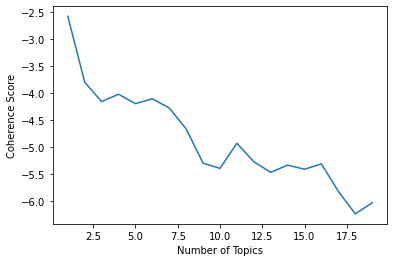

In [36]:
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=id2word, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, coherence='u_mass')
    topics.append(i)
    score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.savefig("u_mass_2020.jpg")
plt.show()

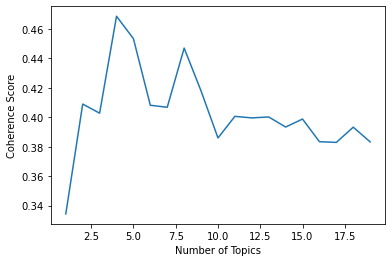

In [37]:
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=id2word, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = df_2020['lemma_tokens'], corpus=corpus, dictionary=id2word, coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.savefig("v_2020.jpg")
plt.show()

In [52]:
""" 2021 """

num_topics = 3

id2word = Dictionary(df_2021['lemma_tokens'])
#id2word.filter_extremes(no_below=2, no_above=.3, keep_n=None)

corpus = [id2word.doc2bow(doc) for doc in df_2021['lemma_tokens']]

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       iterations=50,
                                       num_topics=num_topics)

cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, coherence='u_mass')
cm1 = CoherenceModel(model=lda_model, texts = df_2021['lemma_tokens'], corpus=corpus, dictionary=id2word, coherence='c_v')

# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
pprint(cm.get_coherence())
pprint(cm1.get_coherence())

[(0,
  '0.050*"rhino" + 0.020*"savetherhino" + 0.020*"poach" + 0.012*"horn" + '
  '0.007*"2021" + 0.006*"year" + 0.005*"tweet" + 0.005*"wildlife" + '
  '0.005*"com" + 0.005*"poaching"'),
 (1,
  '0.067*"rhino" + 0.013*"poacher" + 0.012*"horn" + 0.011*"poach" + '
  '0.011*"savetherhino" + 0.009*"poaching" + 0.009*"park" + '
  '0.008*"rhinopoaching" + 0.007*"africa" + 0.007*"south"'),
 (2,
  '0.034*"rhino" + 0.014*"savetherhino" + 0.014*"horn" + 0.009*"poach" + '
  '0.007*"conservation" + 0.007*"wildlife" + 0.006*"africa" + 0.006*"save" + '
  '0.005*"south" + 0.004*"rhinohorn"')]
-2.7496256405674413
0.37615197321037835


In [44]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics()]
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
rhino poach horn poacher africa poaching south year arrest savetherhino

------ Topic 1 ------
rhino savetherhino horn poach rhinopoaching poaching year poacher wildlife save

------ Topic 2 ------
rhino savetherhino horn poach wildlife conservation 2021 assam poaching save



In [45]:
# Visualize the topics
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.038013  0.007958       1        1  39.339338
1     -0.009732 -0.028442       2        1  37.017656
2     -0.028281  0.020484       3        1  23.643007, topic_info=               Term        Freq       Total Category  logprob  loglift
2      savetherhino  371.000000  371.000000  Default  30.0000  30.0000
144            horn  325.000000  325.000000  Default  29.0000  29.0000
516           assam   68.000000   68.000000  Default  28.0000  28.0000
1140           gish   42.000000   42.000000  Default  27.0000  27.0000
33             save  101.000000  101.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
133          africa   21.614274  159.035959   Topic3  -5.6619  -0.5537
26             find   17.805094   81.828036   Topic3  -5.8558  -0.0830
1328  wildlifecrime   18.028730   93.876975   Topic3  -5.8433  -0.2079
687        national   18.254030  114.094517   Topic3  -5.8309  -0.3905
22             year   18.323769  157.697021   Topic3  -5.8271  -0.7104

[269 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
41        1  0.414322      2021
41        2  0.294806      2021
41        3  0.286838      2021
438       1  0.155961        22
438       2  0.389903        22
...     ...       ...       ...
1315      3  0.143257        za
1639      3  0.849802    zazzle
172       1  0.666979  zimbabwe
172       2  0.222326  zimbabwe
172       3  0.133396  zimbabwe

[425 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

### Evaluation

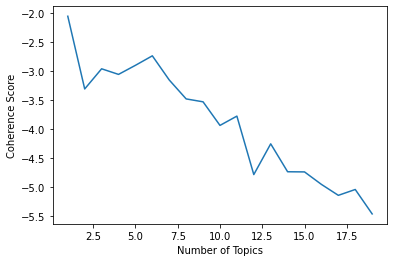

In [46]:
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=id2word, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, coherence='u_mass')
    topics.append(i)
    score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.savefig("u_mass_2021.jpg")
plt.show()

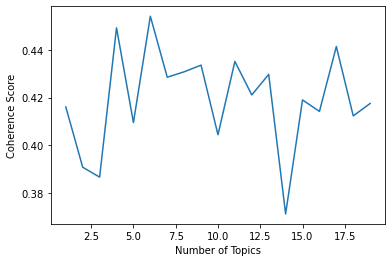

In [53]:
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=id2word, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = df_2021['lemma_tokens'], corpus=corpus, dictionary=id2word, coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.savefig("v_2021.jpg")
plt.show()

In [48]:
""" all years combined """

num_topics = 3

id2word = Dictionary(df['lemma_tokens'])
#id2word.filter_extremes(no_below=5, no_above=.6, keep_n=None)

corpus = [id2word.doc2bow(doc) for doc in df['lemma_tokens']]

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       iterations=50,
                                       num_topics=num_topics)

cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, coherence='u_mass')
cm1 = CoherenceModel(model=lda_model, texts = df['lemma_tokens'], corpus=corpus, dictionary=id2word, coherence='c_v')

# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
pprint(cm.get_coherence())
pprint(cm1.get_coherence())

[(0,
  '0.056*"rhino" + 0.022*"savetherhino" + 0.014*"horn" + 0.011*"poach" + '
  '0.007*"wildlife" + 0.006*"rhinopoaching" + 0.005*"africa" + 0.005*"arrest" '
  '+ 0.005*"tweet" + 0.005*"conservation"'),
 (1,
  '0.057*"rhino" + 0.016*"savetherhino" + 0.016*"poach" + 0.012*"horn" + '
  '0.008*"poaching" + 0.007*"wildlife" + 0.007*"poacher" + '
  '0.006*"conservation" + 0.006*"save" + 0.005*"rhinohorn"'),
 (2,
  '0.042*"rhino" + 0.022*"poach" + 0.011*"savetherhino" + 0.008*"africa" + '
  '0.008*"poacher" + 0.008*"wildlife" + 0.007*"horn" + 0.007*"conservation" + '
  '0.006*"year" + 0.006*"rhinohorn"')]
-2.405148380045006
0.33753068640300604


In [49]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics()]
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
rhino savetherhino horn poach wildlife rhinopoaching africa arrest tweet conservation

------ Topic 1 ------
rhino savetherhino poach horn poaching wildlife poacher conservation save rhinohorn

------ Topic 2 ------
rhino poach savetherhino africa poacher wildlife horn conservation year rhinohorn



In [50]:
# Visualize the topics
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.029423  0.003540       1        1  39.326999
1      0.011279 -0.024525       2        1  32.740679
2      0.018145  0.020985       3        1  27.932322, topic_info=          Term         Freq        Total Category  logprob  loglift
84       poach  1461.000000  1461.000000  Default  30.0000  30.0000
543    poacher   522.000000   522.000000  Default  29.0000  29.0000
127    namibia   176.000000   176.000000  Default  28.0000  28.0000
133     africa   573.000000   573.000000  Default  27.0000  27.0000
146       kill   252.000000   252.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
4128    arrest    93.958164   364.963614   Topic3  -5.6384  -0.0816
114        one    86.009393   314.664389   Topic3  -5.7268  -0.0217
124      world    76.797120   266.701548   Topic3  -5.8401   0.0304
128   poaching   101.206188   520.859729   Topic3  -5.5641  -0.3629
1916      2019    81.992328   312.506626   Topic3  -5.7746  -0.0626

[279 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
234       1  0.314632         1
234       2  0.467453         1
234       3  0.220242         1
40        1  0.299971        12
40        2  0.199981        12
...     ...       ...       ...
22        2  0.280128      year
22        3  0.354990      year
172       1  0.638077  zimbabwe
172       2  0.227112  zimbabwe
172       3  0.129778  zimbabwe

[482 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])